### Data Preprocessing

In [ ]:
# !pip install imbalanced-learn mlflow shap pyngrok --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

In [ ]:
df = pd.read_csv("/content/credit_card_transactions.csv")

In [ ]:
df.shape

(1296675, 24)

In [ ]:
df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN


In [ ]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Unnamed: 0','cc_num', 'first', 'last', 'street', 'city', 'zip',
       'lat', 'long', 'city_pop','trans_num', 'unix_time','merch_lat', 'merch_long', 'merch_zipcode'])

In [ ]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,gender,state,job,dob,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,NC,"Psychologist, counselling",1988-03-09,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,WA,Special educational needs teacher,1978-06-21,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   state                  1296675 non-null  object 
 6   job                    1296675 non-null  object 
 7   dob                    1296675 non-null  object 
 8   is_fraud               1296675 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 89.0+ MB


#### Feature Engineering

In [ ]:
df['dob'] = pd.to_datetime(df['dob'])
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   merchant               1296675 non-null  object        
 2   category               1296675 non-null  object        
 3   amt                    1296675 non-null  float64       
 4   gender                 1296675 non-null  object        
 5   state                  1296675 non-null  object        
 6   job                    1296675 non-null  object        
 7   dob                    1296675 non-null  datetime64[ns]
 8   is_fraud               1296675 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 89.0+ MB


In [ ]:
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

In [ ]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday  # Monday=0, Sunday=6
df['month'] = df['trans_date_trans_time'].dt.month

In [ ]:
df['amt_bin'] = pd.qcut(df['amt'], q=[0, 0.6, 0.85, 0.95, 1.0], labels=['small', 'medium', 'large', 'very_large'])

In [ ]:
categorical_cols_label = ['merchant', 'job', 'state','category', 'amt_bin']  # many unique values
categorical_cols_onehot = ['gender']  # few unique values

In [ ]:
le = LabelEncoder()
for col in categorical_cols_label:
    df[col] = le.fit_transform(df[col])

In [ ]:
df = pd.get_dummies(df, columns=categorical_cols_onehot, drop_first=True)

In [ ]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,state,job,dob,is_fraud,age,hour,day,weekday,month,amt_bin,gender_M
0,2019-01-01 00:00:18,514,8,4.97,27,370,1988-03-09,0,30,0,1,1,1,2,False
1,2019-01-01 00:00:44,241,4,107.23,47,428,1978-06-21,0,40,0,1,1,1,1,False


In [ ]:
df_sample, _ = train_test_split(
    df,
    train_size=100000,           # sample 100k for tuning
    stratify=df['is_fraud'],     # preserve fraud ratio
    random_state=42
)

In [ ]:
X = df_sample.drop(columns=['is_fraud', 'dob', 'trans_date_trans_time', 'amt'])
y = df_sample['is_fraud']

In [ ]:
# Assume X, y are your features and target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X_train

,merchant,category,state,job,age,hour,day,weekday,month,amt_bin,gender_M
292022,429,12,35,231,22,22,23,3,5,2,False
911060,550,4,34,480,34,7,29,6,12,0,False
450564,310,12,4,344,46,14,19,4,7,0,False
909997,676,9,35,352,62,2,29,6,12,0,False
10939,629,9,27,413,25,14,7,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...
1017400,270,4,35,53,56,1,24,0,2,1,True
686598,491,12,23,96,51,5,20,6,10,2,True
237537,328,4,24,458,62,7,29,0,4,0,True
1021579,371,10,2,62,19,17,26,2,2,0,True


In [ ]:
y_train

,is_fraud
292022,0
911060,0
450564,0
909997,0
10939,0
...,...
1017400,0
686598,0
237537,0
1021579,0


In [ ]:
X_test.shape

(20000, 11)

### Using SMOTE

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

In [ ]:
# Apply SMOTE only on training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: is_fraud
0    79537
1      463
Name: count, dtype: int64
After SMOTE: is_fraud
0    79537
1    79537
Name: count, dtype: int64


In [ ]:
# # 50% oversampling of minority class
# smote = SMOTE(sampling_strategy=0.5, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=None,          # Let trees grow fully (can tune later)
    random_state=42,
    class_weight='balanced', # Handles any remaining imbalance
    n_jobs=-1                # Use all CPU cores for faster training
)

In [ ]:
# # X_train_res and y_train_res are after SMOTE
# rf_model.fit(X_train_res, y_train_res)

In [ ]:
# y_pred = rf_model.predict(X_test)
# y_proba = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUCS

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

In [ ]:
mlflow.set_experiment("RandomForest_Amnil")

<Experiment: artifact_location='mlflow-artifacts:/489094512366178248', creation_time=1758785111496, experiment_id='489094512366178248', last_update_time=1758785111496, lifecycle_stage='active', name='RandomForest_Amnil', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
with mlflow.start_run():

    random_search = RandomizedSearchCV(
        rf_model,
        param_distributions=param_grid,
        n_iter=5,
        scoring='roc_auc',
        cv=2,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train_res, y_train_res)

    # Best model
    best_rf = random_search.best_estimator_
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate on test set
    y_pred = best_rf.predict(X_test)
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc)

    # Log parameters
    mlflow.log_params(random_search.best_params_)

    # Log metrics
    mlflow.log_metric("roc_auc", roc_auc)

    # Log model
    mlflow.sklearn.log_model(best_rf, "random_forest_model")

    print("MLflow run completed!")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


2025/09/25 08:31:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[[18142  1742]
 [   41    75]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     19884
           1       0.04      0.65      0.08       116

    accuracy                           0.91     20000
   macro avg       0.52      0.78      0.52     20000
weighted avg       0.99      0.91      0.95     20000

ROC AUC: 0.8854840835466394


2025/09/25 08:31:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run completed!
🏃 View run respected-cat-667 at: http://localhost:2000/#/experiments/489094512366178248/runs/67b38ef9ee3e470d9fc820ef836633b8
🧪 View experiment at: http://localhost:2000/#/experiments/489094512366178248


In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# random_search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_grid,
#     n_iter=10,          # number of random combinations
#     scoring='f1',
#     cv=3,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train_res, y_train_res)

### Feature Importance

In [ ]:
importances = best_rf.feature_importances_
for f, imp in zip(X.columns, importances):
    print(f"{f}: {imp:.3f}")

merchant: 0.028
category: 0.092
state: 0.029
job: 0.027
age: 0.020
hour: 0.114
day: 0.036
weekday: 0.081
month: 0.047
amt_bin: 0.491
gender_M: 0.034


### SHAP Values

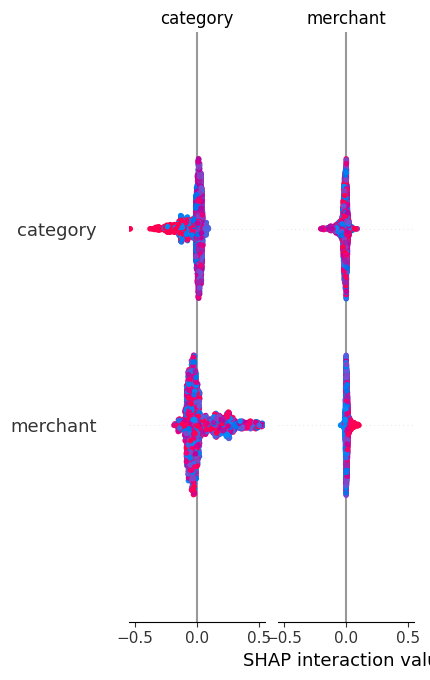

In [ ]:
X_shap = X_test.sample(n=2000, random_state=42)  # sample 2k rows

# Initialize TreeExplainer
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values on the subset
shap_expl = explainer(X_shap)

shap.summary_plot(shap_expl)

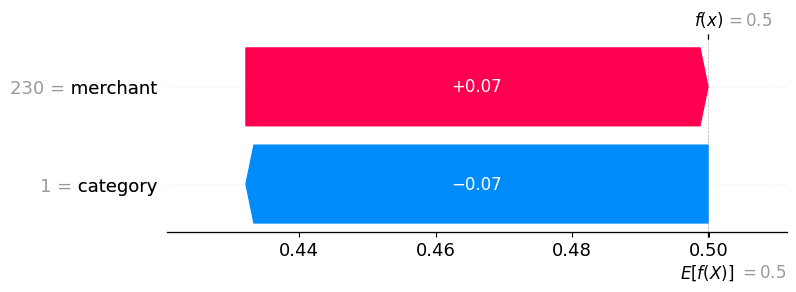

In [ ]:
single_expl = shap.Explanation(
    values=shap_expl.values[0, 1],         # SHAP values for fraud class
    base_values=shap_expl.base_values[0, 1],  # base value for fraud class
    data=X_shap.iloc[0].values,            # feature values
    feature_names=X_shap.columns.tolist()  # feature names
)
shap.plots.waterfall(single_expl)

### Setting up MLflow using ngrok

In [ ]:
from google.colab import userdata
ngrok_token = userdata.get("ngrokToken")

In [ ]:
get_ipython().system_raw("mlflow ui --port 2000 &")
mlflow.set_tracking_uri("http://localhost:2000")
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_token)

In [ ]:
public_url = ngrok.connect(2000).public_url
print(public_url)

https://dino-advisory-unprimitively.ngrok-free.dev
